# Community discovery con grafo non direzionato pesato ed unica componente connessa gigante

In [1]:
%matplotlib inline

import warnings
from collections import Counter
import numpy as np
warnings.filterwarnings('ignore')
import networkx as nx
import pandas as pd
from cdlib import algorithms, ensemble, evaluation, viz, NodeClustering
from networkx.generators.community import LFR_benchmark_graph
import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')

In [2]:
def clustering_evaluation(method):
    print('Evaluating: ' + str(method.method_name))
    print("Node coverage: ", method.node_coverage)
    print("Overlapping: ", method.overlap)
    print("N_communities: ", len(method.communities))
    print("Number of nodes: ", method.size())
    print("Average internal degree: ", method.average_internal_degree())
    print("Internal edge density: ", method.internal_edge_density())
    print("Conductance: ", method.conductance())
    print("Cut ratio: ", method.cut_ratio())
    print("Newman Girvan modularity: ", method.newman_girvan_modularity())
    return
    
def clustering_comparator_AMI(method, list_of_methods): #Adjusted_Mutual_Information
    for methods in list_of_methods:
        eval = evaluation.normalized_mutual_information(method, methods)
        print('Comparison between ' + str(method.method_name) +' and ' + str(methods.method_name) + ' using Adjusted Mutual Information \n' + str(eval) +'\n')
    return

def clustering_comparator_ONMI(method, list_of_methods): #Overlapping_Normalized_Mutual_Information_LFK
    for methods in list_of_methods:
        eval = evaluation.overlapping_normalized_mutual_information_LFK(method, methods)
        print('Comparison between ' + str(method.method_name) +' and ' + str(methods.method_name) + ' using Overlapping Normalized Mutual Information LFK \n' + str(eval) +'\n')
    return

def modularity_vs_conductance(graph, lower_range, upper_range, algorithm):
    n_com = []
    condu = []
    modu = []
    for i in range(lower_range, upper_range):
        coms = algorithm(graph, i)
        n_com.append(i)
        condu.append(coms.conductance()[2])
        modu.append(coms.newman_girvan_modularity()[2])

    plt.plot(n_com, condu, '-g', label='conductance')
    plt.plot(n_com, modu, '-b', label='modularity')
    plt.legend();
    
    return

In [3]:
G = nx.read_gexf("../../data_collection/data/RW_Graphs/SCC_weighted_graph_un.gexf")

In [4]:
len(G.nodes())

46978

## Community Discovery algorithms

### Label propagation

In [5]:
lp_coms = algorithms.label_propagation(G)

In [6]:
lp_coms.method_parameters # Clustering parameters

{'': ''}

### Leiden

https://www.nature.com/articles/s41598-019-41695-z

In [7]:
leiden_coms = algorithms.leiden(G, weights = 'weight')

In [8]:
leiden_coms.method_parameters # Clustering parameters

{'initial_membership': None, 'weights': 'weight'}

### Louvain

In [9]:
resolution_mod = ensemble.Parameter(name="resolution", start=0.1, end=1, step=0.1)
randomize_mod = ensemble.BoolParameter(name="randomize")

coms_mod, scoring_mod = ensemble.grid_search(graph=G, method=algorithms.louvain,
                                                     parameters=[resolution_mod, randomize_mod],
                                                     quality_score=evaluation.newman_girvan_modularity,
                                                     aggregate=max)

print("Configuration: %s \nScoring: %s" %(coms_mod.method_parameters, scoring_mod))

Configuration: {'weight': 'weight', 'resolution': 0.9, 'randomize': True} 
Scoring: FitnessResult(min=None, max=None, score=0.5878702063448524, std=None)


In [9]:
louvain_coms = algorithms.louvain(G, weight= 'weight', resolution= 0.9, randomize=True)

In [10]:
louvain_coms.method_parameters # Clustering parameters

{'weight': 'weight', 'resolution': 0.9, 'randomize': True}

### Demon

In [13]:
eps = ensemble.Parameter(name="epsilon", start=0.1, end=1, step=0.1)
size = ensemble.Parameter(name="min_com_size", start=3, end=8, step=1)

coms_demon, scoring_demon = ensemble.random_search(graph=G, method = algorithms.demon,
                                                       parameters = [eps, size],
                                                       quality_score = evaluation.conductance,
                                                       aggregate = min)

print("Configuration: %s \nScoring: %s" %(coms_demon.method_parameters, scoring_demon))

Configuration: {'epsilon': 0.1, 'min_com_size': 3} 
Scoring: FitnessResult(min=0.3333333333333333, max=0.9474641664834176, score=0.8061980287220816, std=0.1256258889785383)


In [11]:
demon_coms = algorithms.demon(G, min_com_size = 3, epsilon = 0.1)

In [12]:
demon_coms.method_parameters # Clustering parameters

{'epsilon': 0.1, 'min_com_size': 3}

### Angel

In [17]:
threshold = ensemble.Parameter(name="threshold", start=0, end=1, step=0.1)
size_ang = ensemble.Parameter(name="min_community_size", start=3, end=8, step=1)

coms_angel, scoring_angel = ensemble.random_search(graph=G, method = algorithms.angel,
                                                       parameters = [threshold, size_ang],
                                                       quality_score = evaluation.conductance,
                                                        aggregate = min)

print("Configuration: %s \nScoring: %s" %(coms_angel.method_parameters, scoring_angel))

Configuration: {'threshold': 0.4, 'min_community_size': 3} 
Scoring: FitnessResult(min=0.3333333333333333, max=1.0, score=0.9361292267231176, std=0.12195554756645827)


In [13]:
angel_coms = algorithms.angel(G, min_community_size = 6, threshold = 0.1)

In [14]:
angel_coms.method_parameters # Clustering parameters

{'threshold': 0.1, 'min_community_size': 6}

### K-Cliques

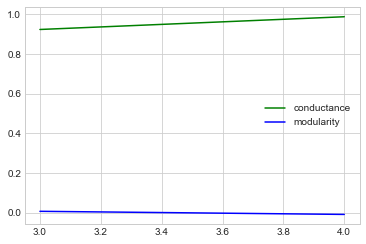

In [16]:
modularity_vs_conductance(G, 3, 5, algorithms.kclique)

In [15]:
kclique_coms = algorithms.kclique(G, k=3)

In [16]:
kclique_coms.method_parameters # Clustering parameters

{'k': 3}

### Principled Clustering

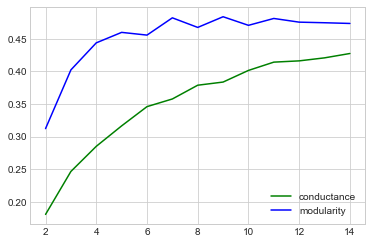

In [19]:
modularity_vs_conductance(G, 2, 15, algorithms.principled_clustering)

In [17]:
principled_coms = algorithms.principled_clustering(G, 4)

In [18]:
principled_coms.method_parameters # Clustering parameters

{'cluster_count': 4}

<a id="fitness"></a>
## Clustering Evaluation

In [19]:
clustering_evaluation(lp_coms)

Evaluating: Label Propagation
Node coverage:  1.0
Overlapping:  False
N_communities:  1781
Number of nodes:  FitnessResult(min=1, max=14817, score=26.377316114542392, std=441.3949103023954)
Average internal degree:  FitnessResult(min=1.0, max=3.121954511709523, score=1.4672282063192996, std=0.47112748030216034)
Internal edge density:  FitnessResult(min=0, max=2.0, score=0.6835315781112684, std=0.5000656983988425)
Conductance:  FitnessResult(min=0.09090909090909091, max=0.8461538461538461, score=0.4800813879951149, std=0.13412875480938552)
Cut ratio:  FitnessResult(min=4.257765099099483e-06, max=0.0001915831151414522, score=3.225929566468372e-05, std=2.0054615486072486e-05)
Newman Girvan modularity:  FitnessResult(min=None, max=None, score=0.45504989882964947, std=None)


In [20]:
clustering_evaluation(leiden_coms)

Evaluating: Leiden
Node coverage:  1.0
Overlapping:  False
N_communities:  40
Number of nodes:  FitnessResult(min=1, max=8997, score=1174.45, std=2095.489596132608)
Average internal degree:  FitnessResult(min=1.0, max=3.0, score=2.3277093230938597, std=0.33320153033936084)
Internal edge density:  FitnessResult(min=0, max=3.0, score=0.18006362246274668, std=0.5853733523034086)
Conductance:  FitnessResult(min=0.2, max=0.5643564356435643, score=0.379609221114745, std=0.08154012835221733)
Cut ratio:  FitnessResult(min=1.0643732970027248e-05, max=6.92387539521424e-05, score=3.301704525500552e-05, std=1.343956244750479e-05)
Newman Girvan modularity:  FitnessResult(min=None, max=None, score=0.5952775850711538, std=None)


In [21]:
clustering_evaluation(louvain_coms)

Evaluating: Louvain
Node coverage:  1.0
Overlapping:  False
N_communities:  31
Number of nodes:  FitnessResult(min=1, max=9942, score=1515.4193548387098, std=2462.5205913557747)
Average internal degree:  FitnessResult(min=1.0, max=2.7818102317446436, score=2.2459849479703022, std=0.40449647421163276)
Internal edge density:  FitnessResult(min=0, max=2.0, score=0.15634144152868584, std=0.42176696430267313)
Conductance:  FitnessResult(min=0.16666666666666666, max=0.6, score=0.37530551676353646, std=0.10304470162003045)
Cut ratio:  FitnessResult(min=7.096426239745664e-06, max=6.767578039358182e-05, score=3.182059688903437e-05, std=1.4129774403930638e-05)
Newman Girvan modularity:  FitnessResult(min=None, max=None, score=0.5874453870585455, std=None)


In [22]:
clustering_evaluation(demon_coms)

Evaluating: DEMON
Node coverage:  0.16939844182383243
Overlapping:  True
N_communities:  18
Number of nodes:  FitnessResult(min=4, max=3360, score=1501.2222222222222, std=1294.4358941062385)
Average internal degree:  FitnessResult(min=3.0, max=9.745019920318725, score=6.846684445974502, std=2.8818938763024575)
Internal edge density:  FitnessResult(min=0.0027619472915692026, max=1.0, score=0.2609651334676088, std=0.4055916090348452)
Conductance:  FitnessResult(min=0.3333333333333333, max=0.9854842054330545, score=0.7383138506918, std=0.139366192129384)
Cut ratio:  FitnessResult(min=3.193255843658194e-05, max=0.0059571040042585965, score=0.0008168537214959202, std=0.0012770820104577721)
Newman Girvan modularity:  FitnessResult(min=None, max=None, score=-0.05007409308070231, std=None)


In [23]:
clustering_evaluation(angel_coms)

Evaluating: ANGEL
Node coverage:  0.10545361658648729
Overlapping:  True
N_communities:  3
Number of nodes:  FitnessResult(min=6, max=4937, score=1651.3333333333333, std=2323.3180774248044)
Average internal degree:  FitnessResult(min=2.0, max=8.618189183714806, score=4.8121236672988745, std=2.791779279411798)
Internal edge density:  FitnessResult(min=0.001745986463475447, max=0.4, score=0.2611880560938858, std=0.18360335009413123)
Conductance:  FitnessResult(min=0.5750681620709285, max=0.8787878787878788, score=0.6806971116588181, std=0.14017443266140164)
Cut ratio:  FitnessResult(min=0.00011613570069507217, max=0.0003086945414289364, score=0.00023408453629983678, std=8.437384056069055e-05)
Newman Girvan modularity:  FitnessResult(min=None, max=None, score=-0.2506626923049016, std=None)


In [24]:
clustering_evaluation(kclique_coms)

Evaluating: Klique
Node coverage:  0.19255821874068713
Overlapping:  True
N_communities:  912
Number of nodes:  FitnessResult(min=3, max=7336, score=11.459429824561404, std=242.67588688075114)
Average internal degree:  FitnessResult(min=2.0, max=8.44165757906216, score=2.7903533732149493, std=0.4767408513157473)
Internal edge density:  FitnessResult(min=0.0011508735622443298, max=2.0, score=1.227000017530688, std=0.24557503685987703)
Conductance:  FitnessResult(min=0.2, max=0.9994290375203915, score=0.9237073672605565, std=0.13559379178724262)
Cut ratio:  FitnessResult(min=1.4191946070604932e-05, max=0.13042853493421894, score=0.022246380111091636, std=0.032061596864306124)
Newman Girvan modularity:  FitnessResult(min=None, max=None, score=0.014092379527383432, std=None)


In [25]:
clustering_evaluation(principled_coms)

Evaluating: Principled Clustering
Node coverage:  1.0
Overlapping:  False
N_communities:  4
Number of nodes:  FitnessResult(min=9833, max=13549, score=11744.5, std=1326.2566682207482)
Average internal degree:  FitnessResult(min=2.375083031958078, max=3.1328659222712716, score=2.740645492909629, std=0.2695523522871248)
Internal edge density:  FitnessResult(min=0.00017530875641851772, max=0.00028120135142146427, score=0.0002377700636074071, std=4.2167249939167315e-05)
Conductance:  FitnessResult(min=0.2746207425106508, max=0.2971743233111864, score=0.2838438929690003, std=0.008538582156050679)
Cut ratio:  FitnessResult(min=2.6898224635704415e-05, max=3.524855318384462e-05, score=3.08383085611431e-05, std=3.0246540274911663e-06)
Newman Girvan modularity:  FitnessResult(min=None, max=None, score=0.4490892614225601, std=None)


## Clustering Evaluation: Valutazione delle somiglianze tra metodi diversi

Ho deciso di utilizzare l' Adjusted Mutual Information perchè la MI soffre di bias nel momento in cui si hanno clustering con un numero elevato di cluster (come nel nostro caso). Infatti, anche se esse non condividono maggiore informazioni, è probabile avere comunque una misura che sovrastima la loro somiglianza.
Per gli algoritmi che vanno a creare dei cluster con una copertura dei nodi del grafo non completa ho deciso invece di utilizzare l'overlapping normalized mutual information.

In ogni caso tale comparazioni soffrono il fatto che stiamo comparando algoritmi di famiglie diverse e che quindi utilizzano anche funzioni di qualità, o principi, diversi l'uno dall'altro nella costruzione delle comunità.

In [26]:
clustering_comparator_AMI(lp_coms, [louvain_coms, leiden_coms, principled_coms])

Comparison between Label Propagation and Louvain using Adjusted Mutual Information 
MatchingResult(score=0.506550841297051, std=None)

Comparison between Label Propagation and Leiden using Adjusted Mutual Information 
MatchingResult(score=0.5344951838644774, std=None)

Comparison between Label Propagation and Principled Clustering using Adjusted Mutual Information 
MatchingResult(score=0.3296320228848599, std=None)



In [27]:
clustering_comparator_AMI(louvain_coms, [leiden_coms, principled_coms])

Comparison between Louvain and Leiden using Adjusted Mutual Information 
MatchingResult(score=0.7568877064318904, std=None)

Comparison between Louvain and Principled Clustering using Adjusted Mutual Information 
MatchingResult(score=0.2979741361445437, std=None)



In [ ]:
clustering_comparator_AMI(leiden_coms, [principled_coms])

Comparison between Leiden and Principled Clustering using Adjusted Mutual Information 
MatchingResult(score=0.3084670397302126, std=None)



In [ ]:
clustering_comparator_ONMI(demon_coms, [angel_coms, kclique_coms])

Comparison between DEMON and ANGEL using Overlapping Normalized Mutual Information LFK 
MatchingResult(score=0.02683122497520074, std=None)

Comparison between DEMON and Klique using Overlapping Normalized Mutual Information LFK 
MatchingResult(score=0.15421351304109776, std=None)



In [ ]:
clustering_comparator_ONMI(angel_coms, [kclique_coms])

Comparison between ANGEL and Klique using Overlapping Normalized Mutual Information LFK 
MatchingResult(score=0.37217390968715836, std=None)



<a id="visualization"></a>
## Community/Statistics Visualization


### Graph visualization


In [34]:
pos = nx.spring_layout(G)

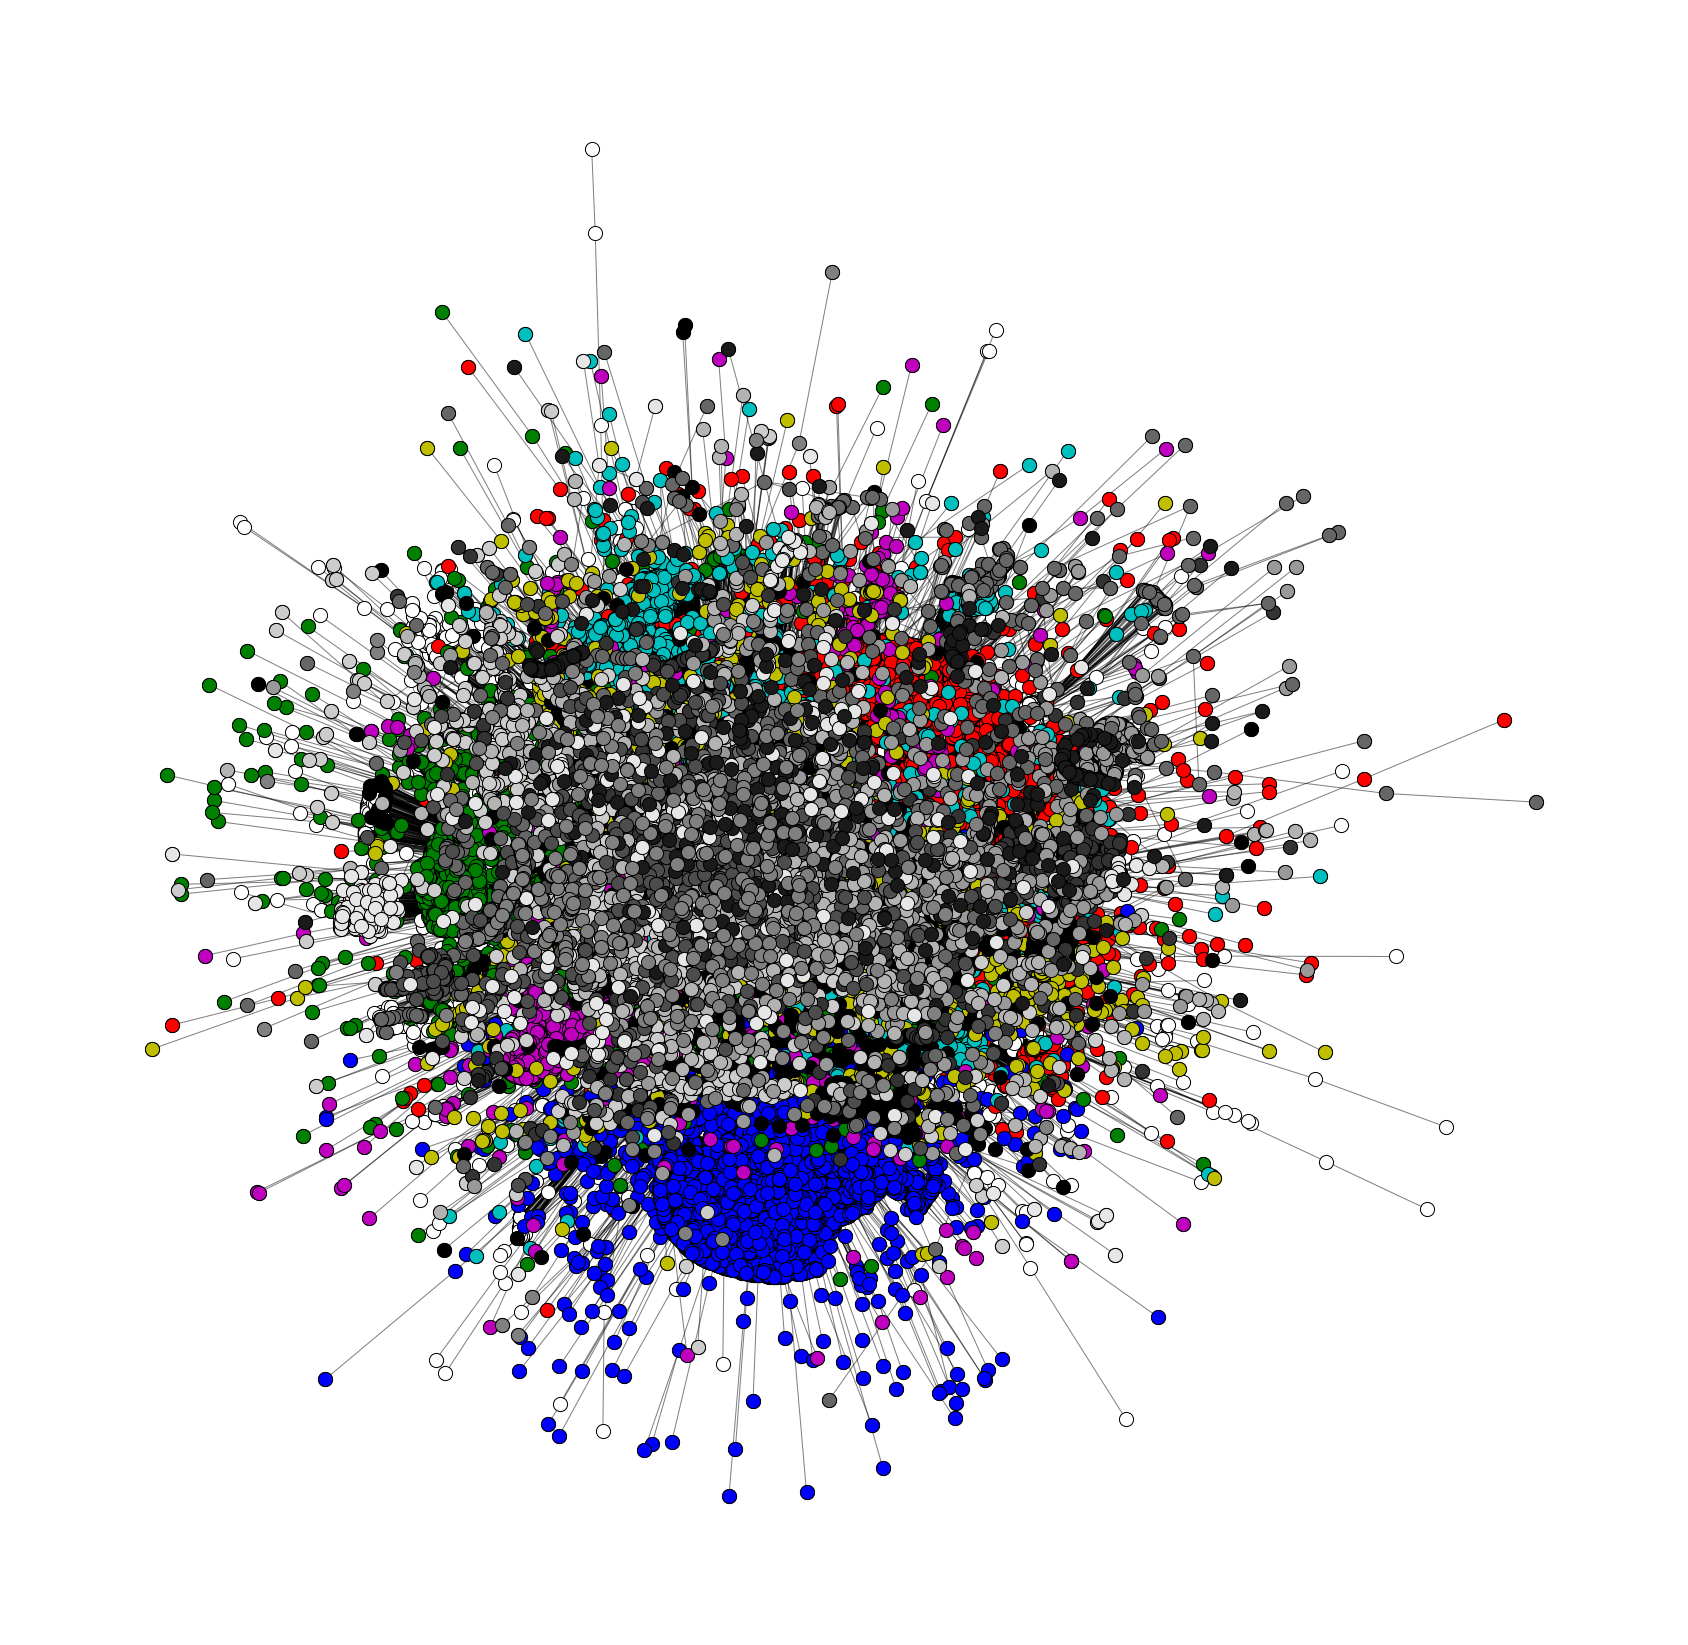

In [36]:
viz.plot_network_clusters(G, louvain_coms, pos, figsize=(30, 30), plot_labels=False)

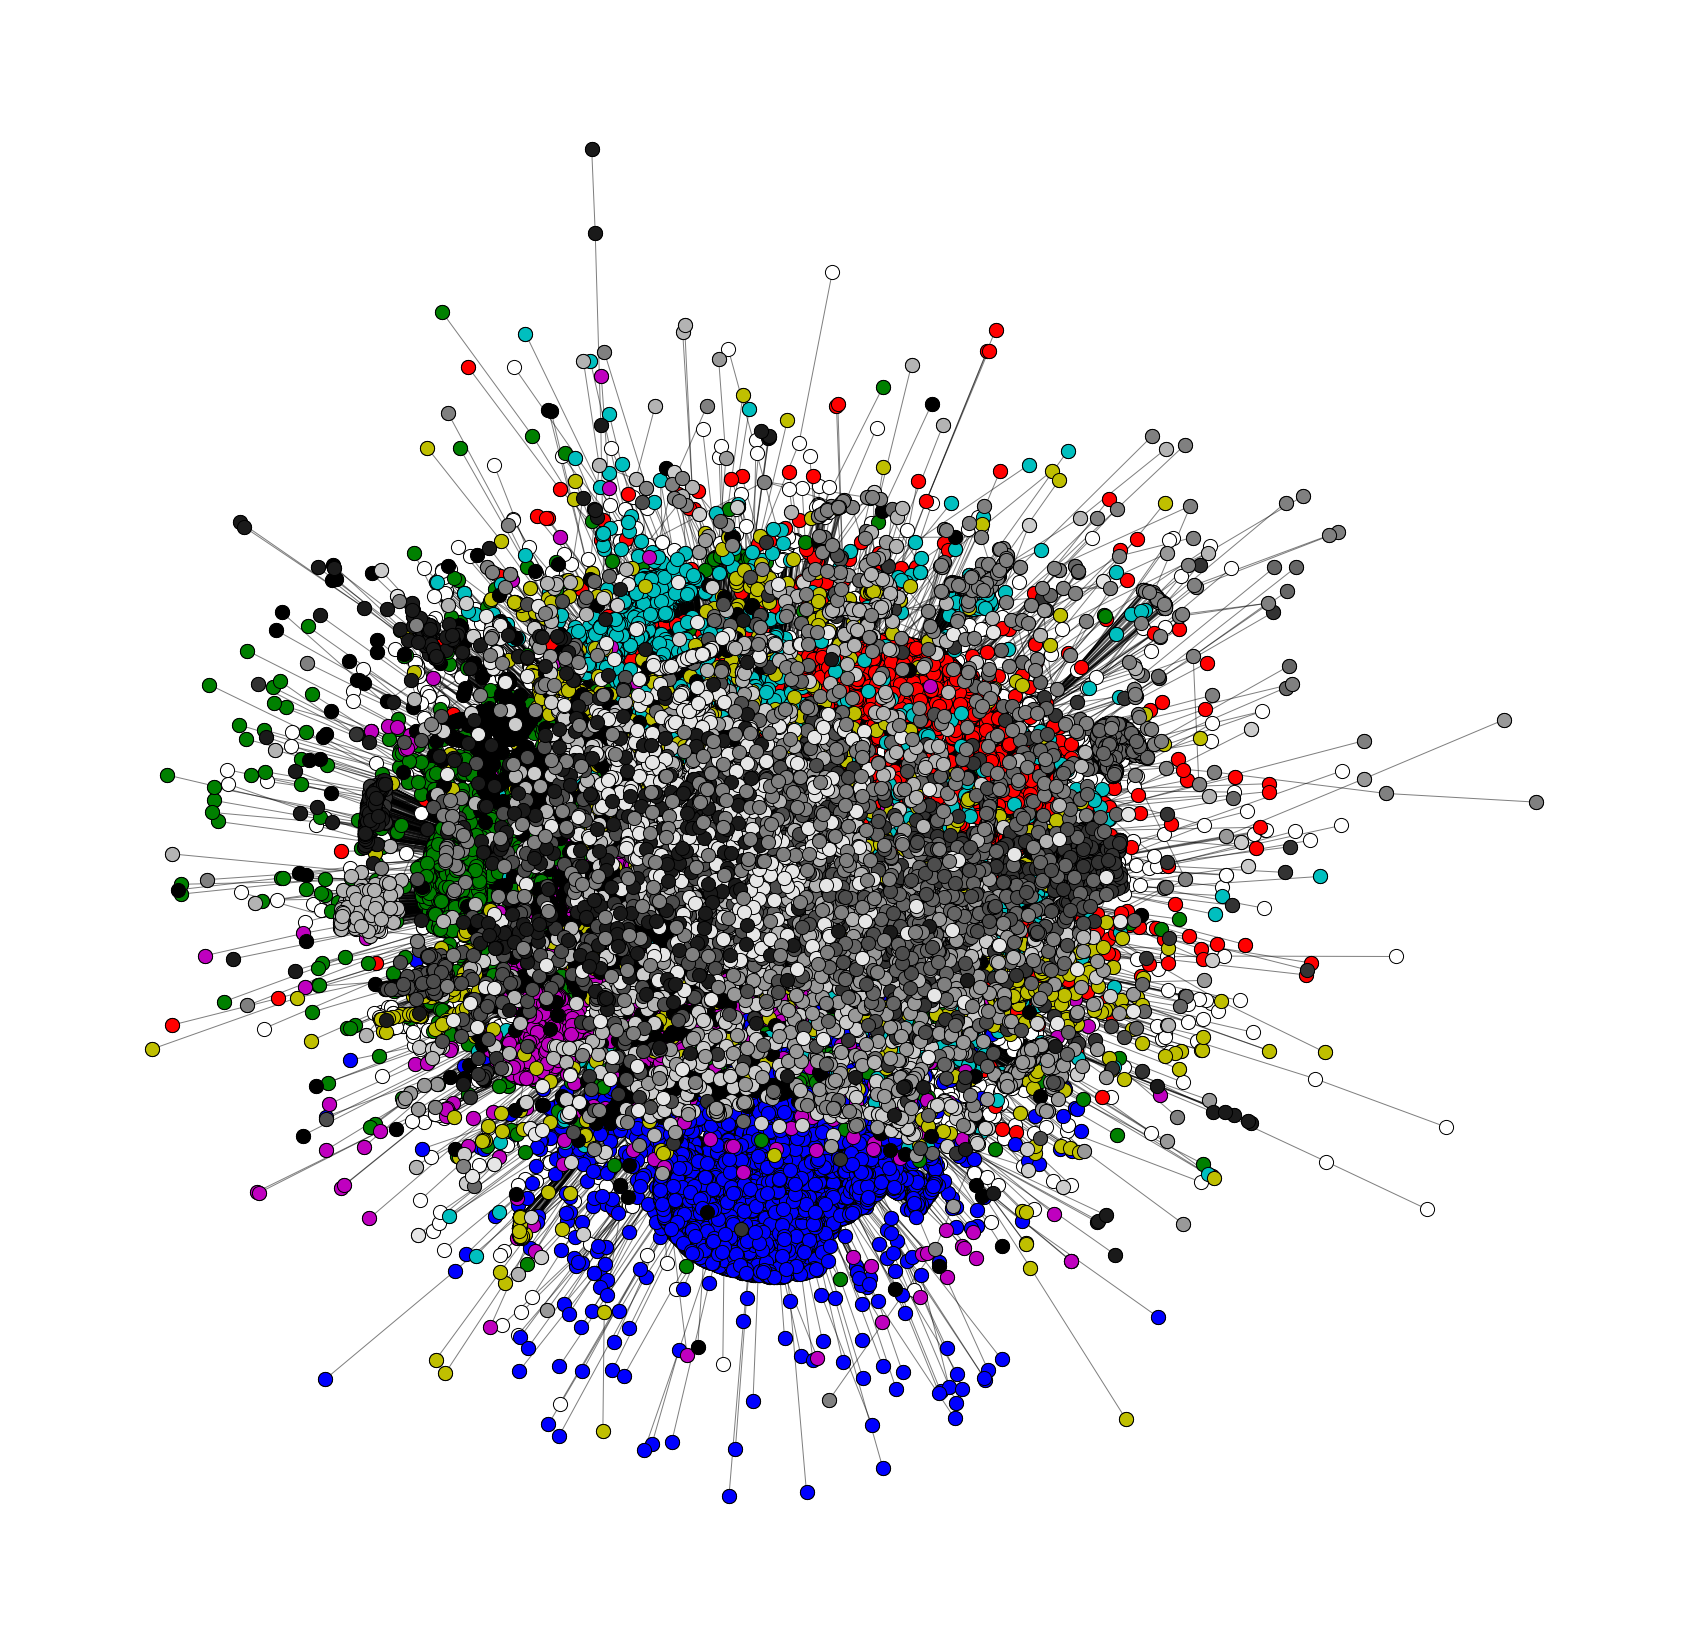

In [39]:
viz.plot_network_clusters(G, leiden_coms, pos, figsize=(30, 30), plot_labels=False)

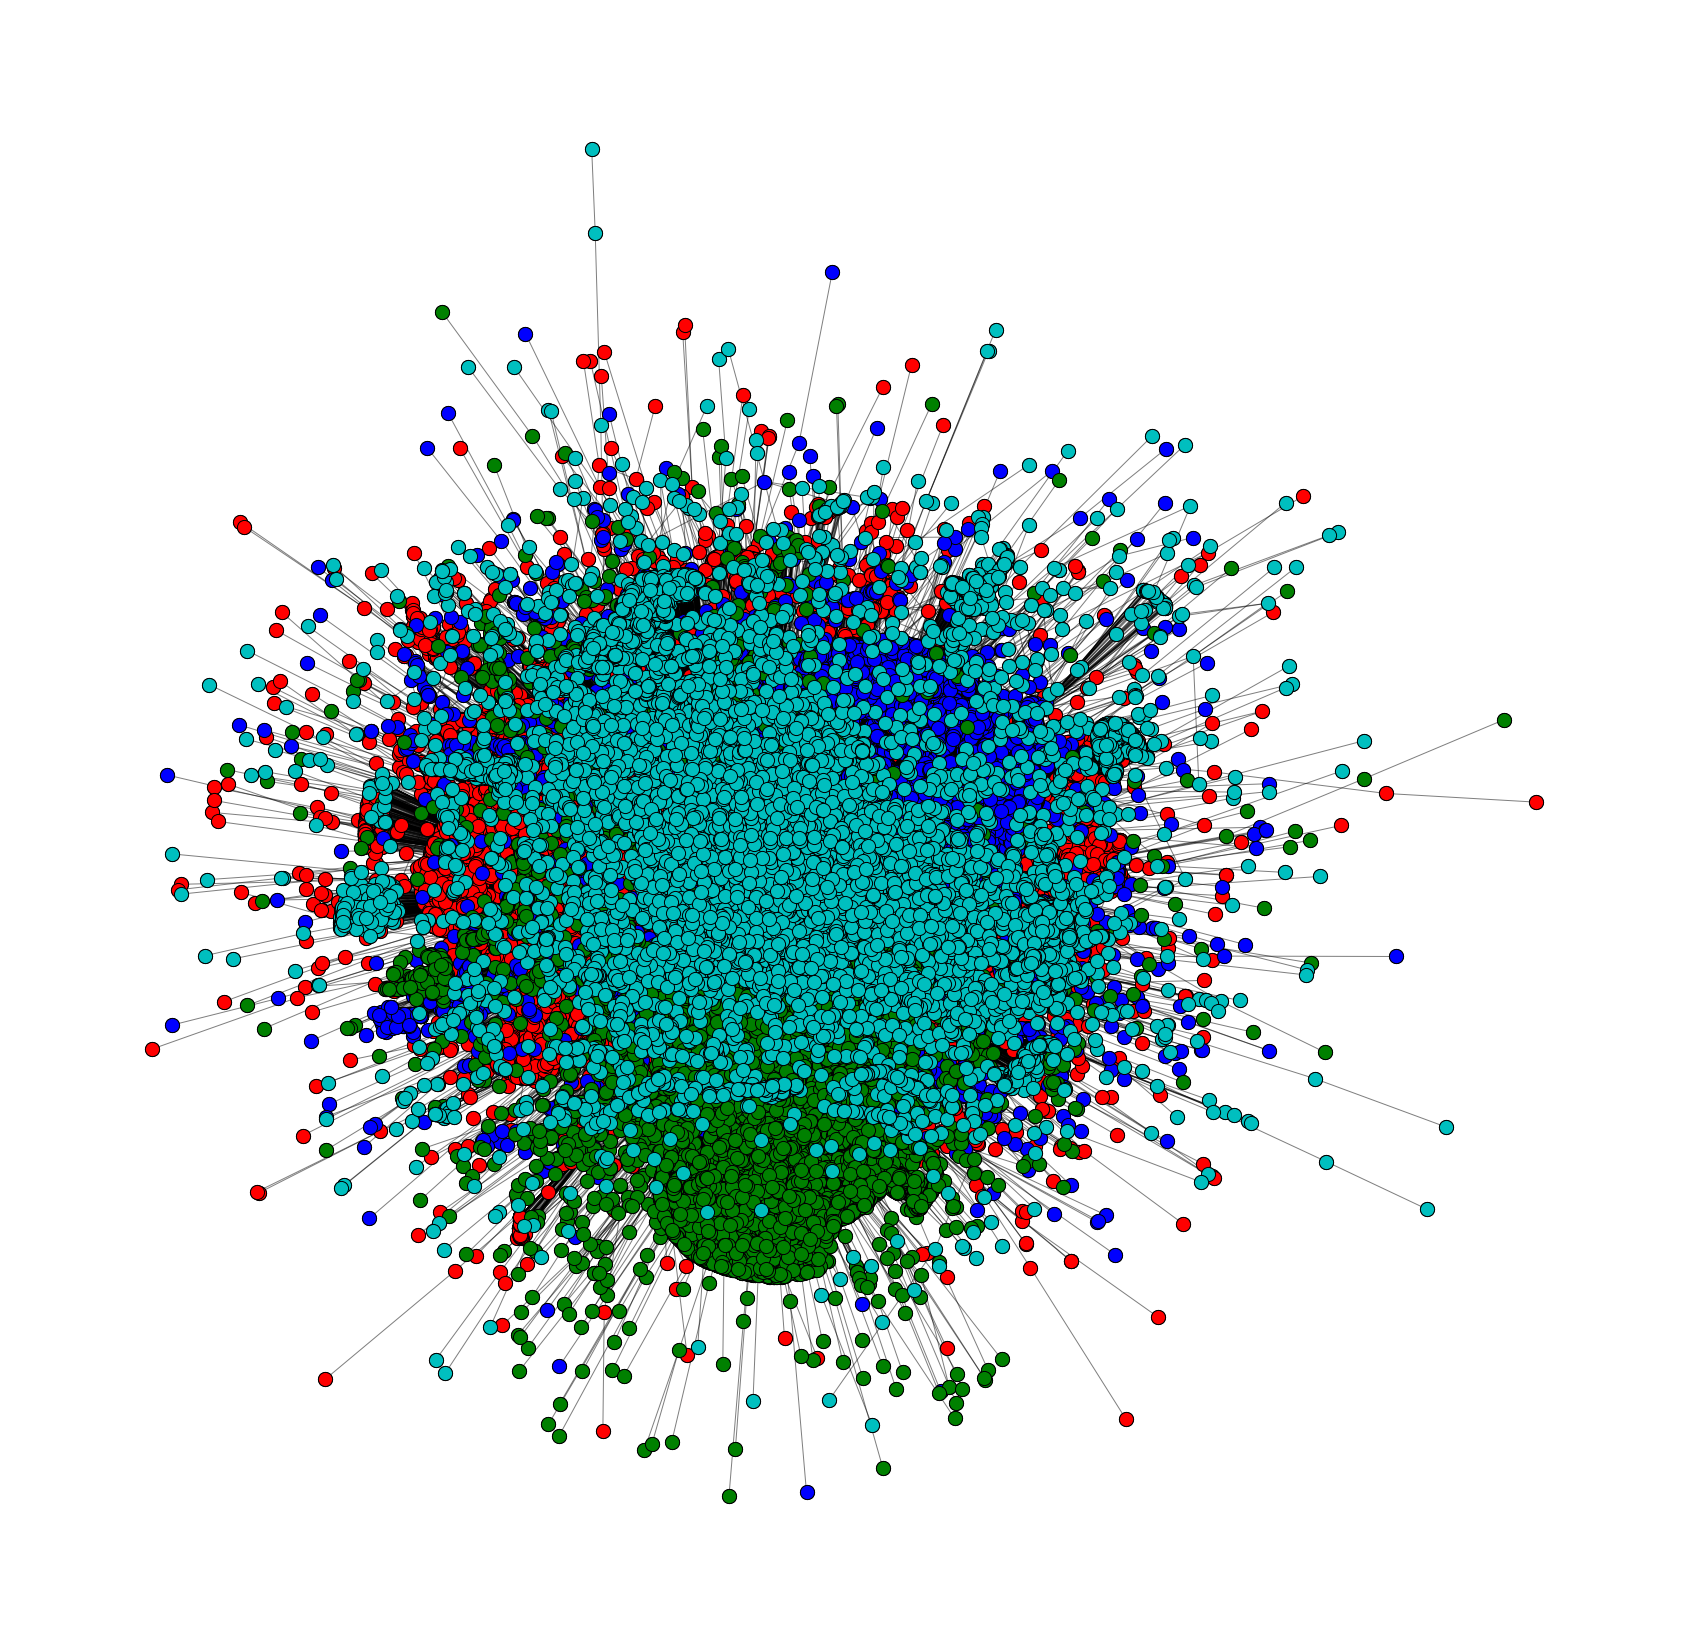

In [40]:
viz.plot_network_clusters(G, principled_coms, pos, figsize=(30, 30), plot_labels=False)

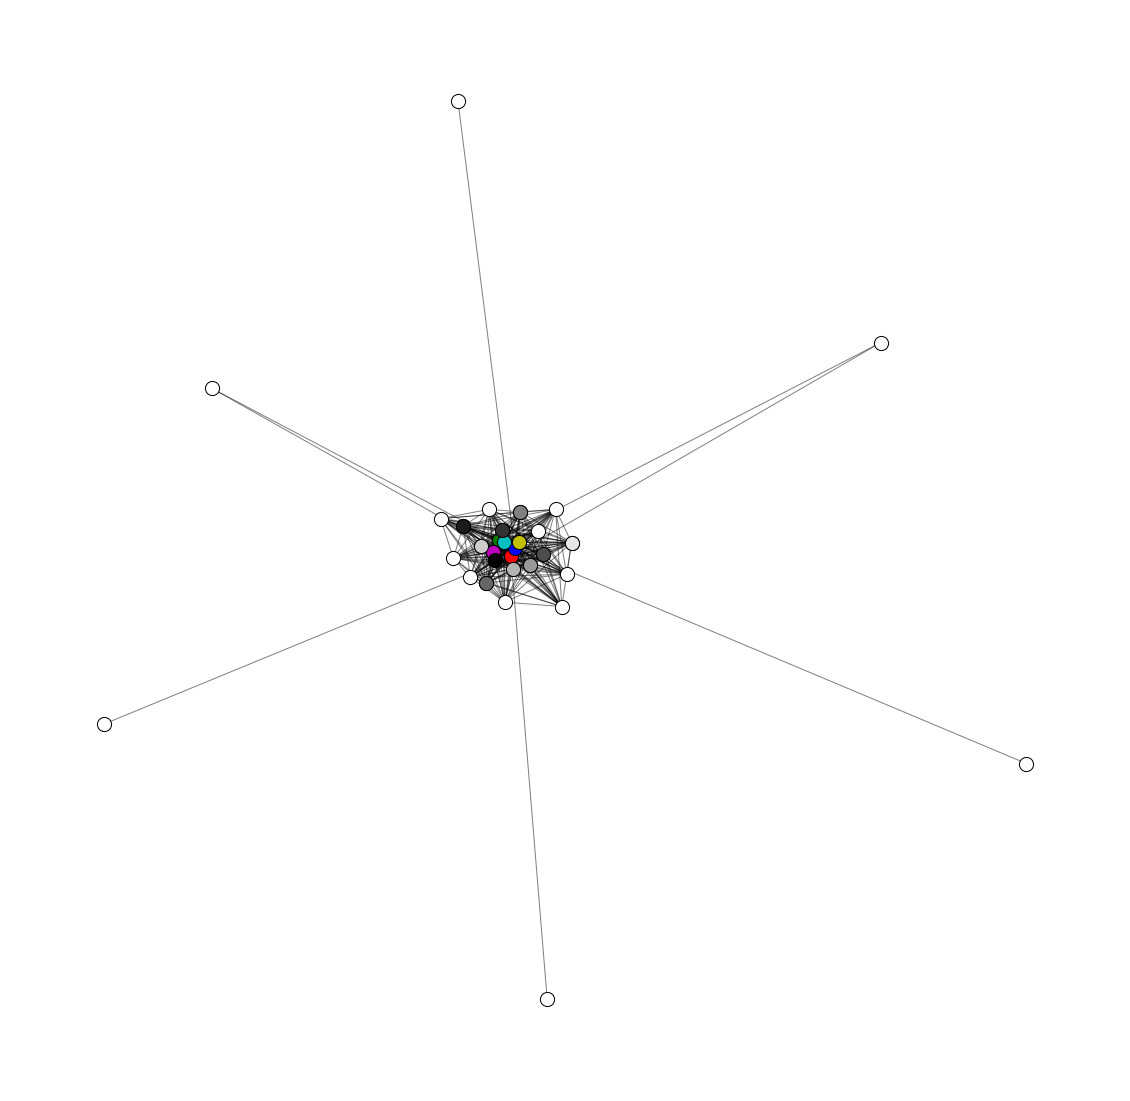

In [41]:
viz.plot_community_graph(G, louvain_coms, figsize=(20, 20))

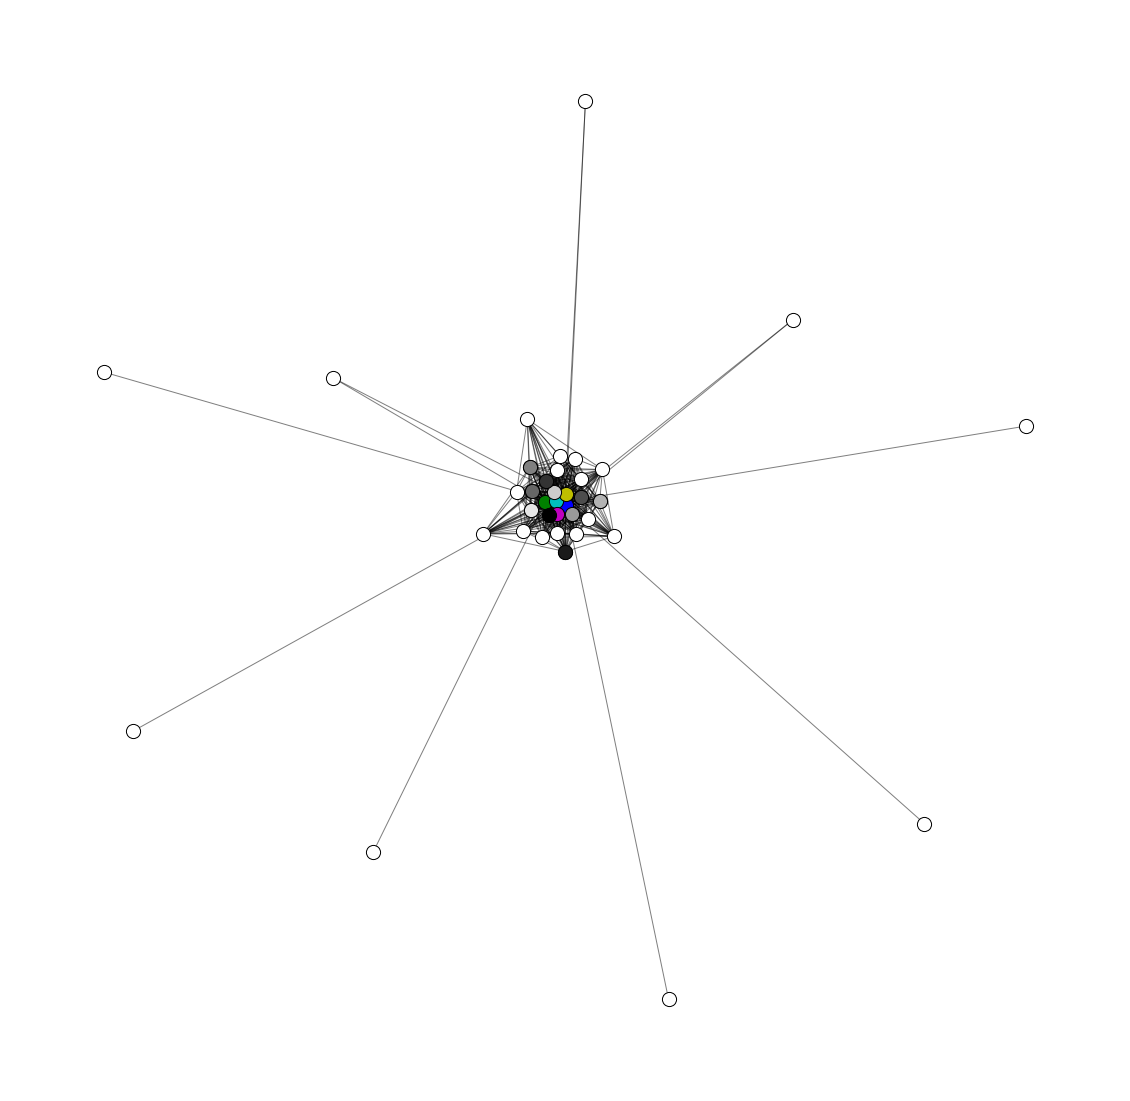

In [42]:
viz.plot_community_graph(G, leiden_coms, figsize=(20, 20))

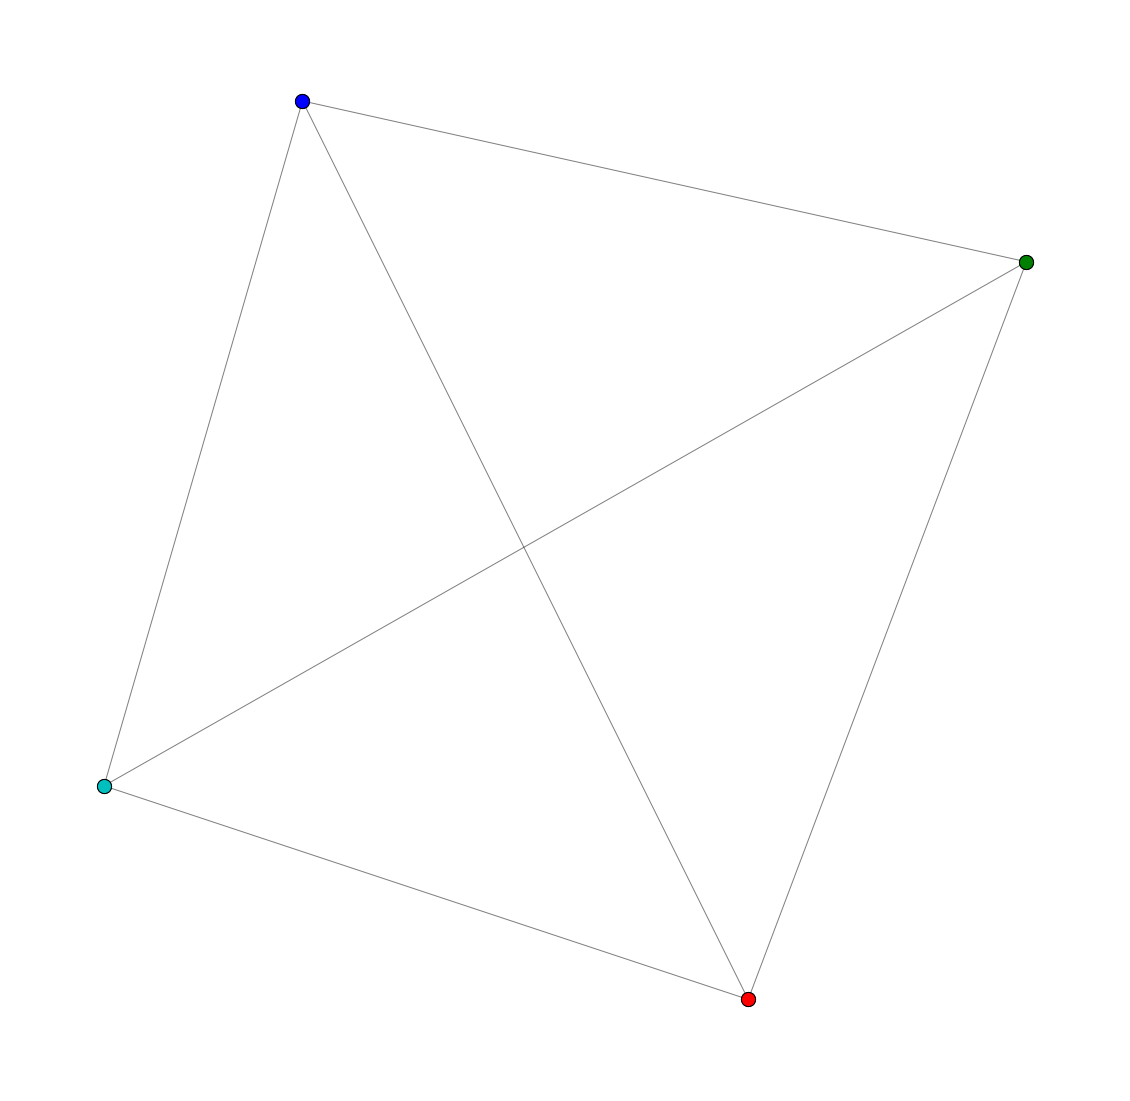

In [43]:
viz.plot_community_graph(G, principled_coms, figsize=(20, 20))

#### Community fitness/comparison visualization

In [1]:
#viz.plot_com_stat([lp_coms, louvain_coms, leiden_coms, principled_coms], evaluation.conductance)

<AxesSubplot:xlabel='Algorithm', ylabel='conductance'>

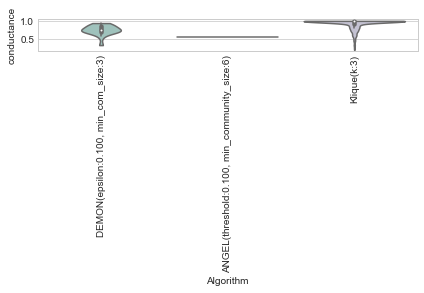

In [45]:
viz.plot_com_stat([demon_coms, angel_coms, kclique_coms], evaluation.conductance)

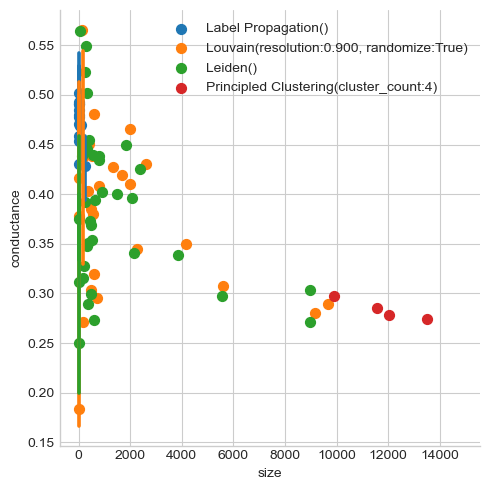

In [39]:
viz.plot_com_properties_relation( [lp_coms, louvain_coms, leiden_coms, principled_coms], evaluation.size, evaluation.conductance)

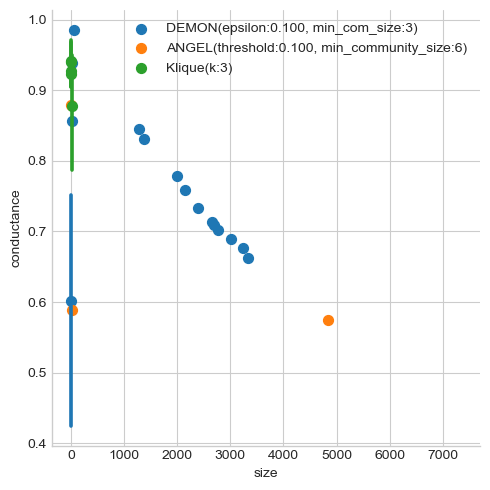

In [41]:
viz.plot_com_properties_relation( [demon_coms, angel_coms, kclique_coms], evaluation.size, evaluation.conductance)

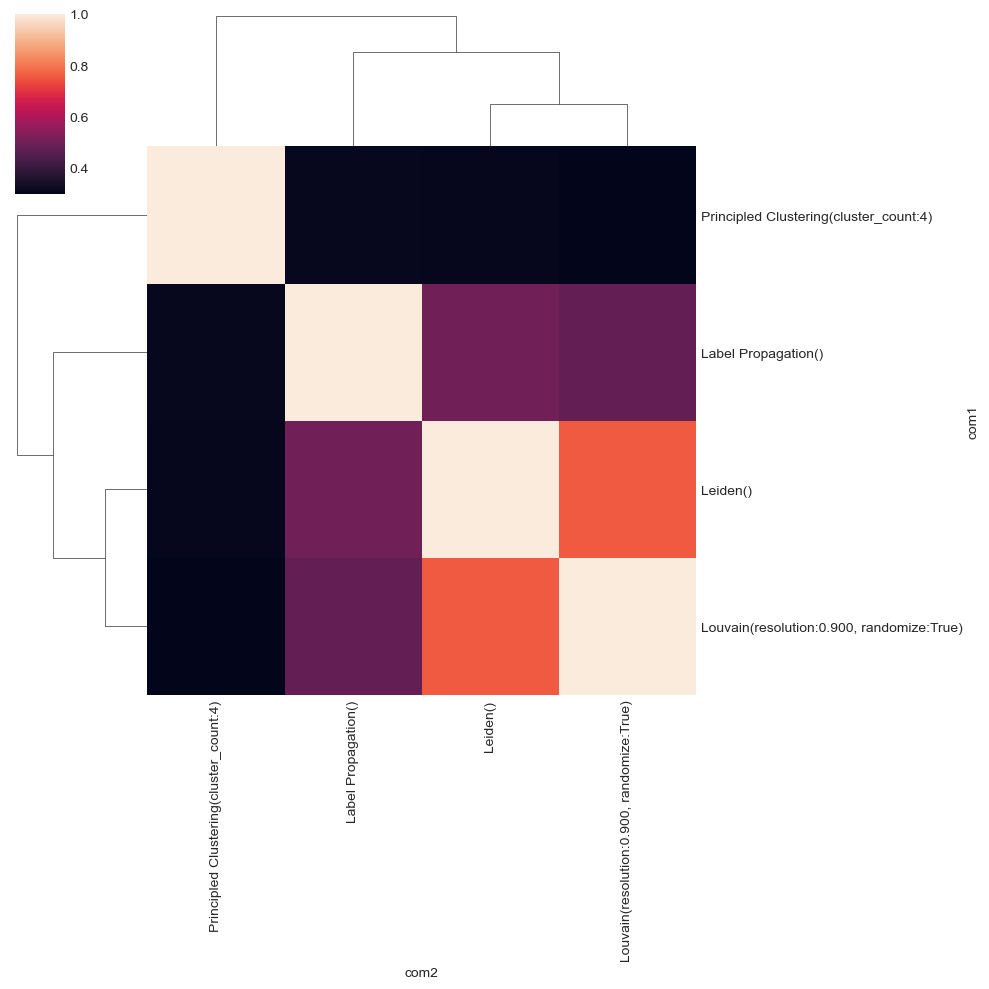

In [44]:
viz.plot_sim_matrix([lp_coms, louvain_coms, leiden_coms, principled_coms],evaluation.adjusted_mutual_information)

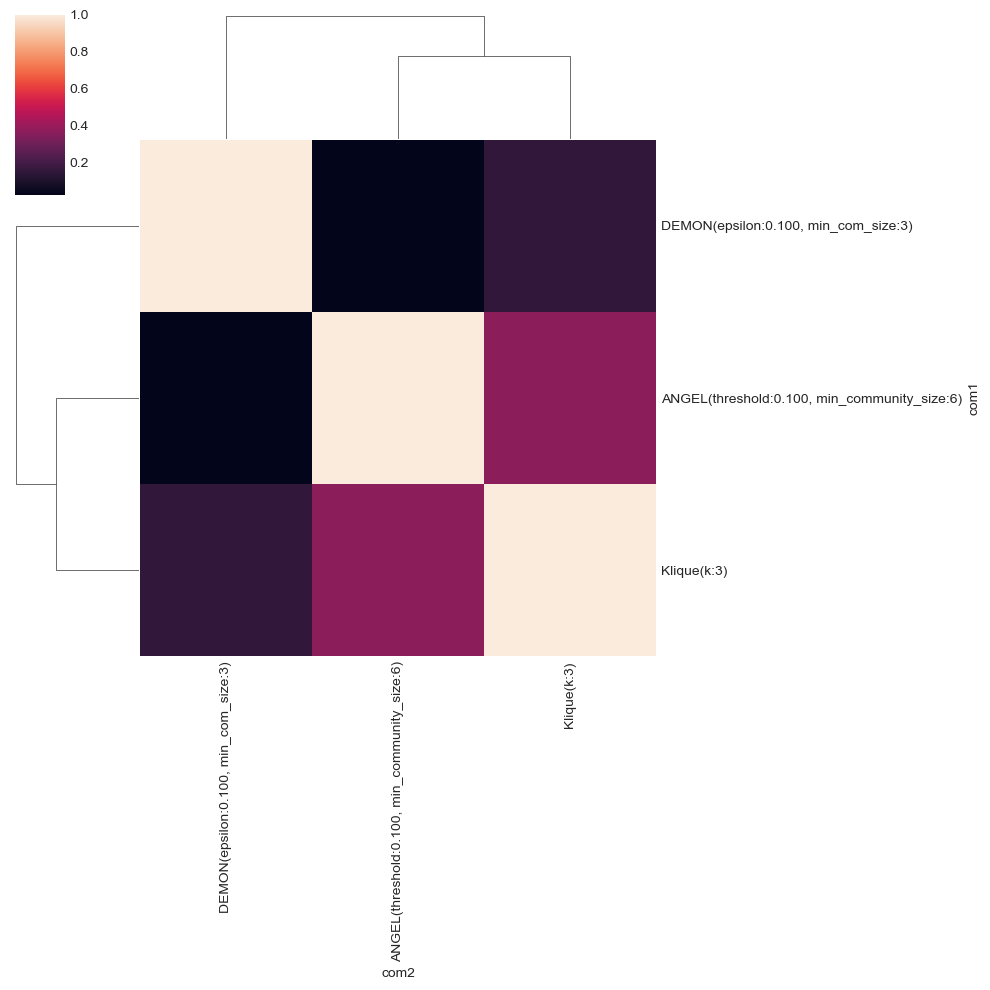

In [43]:
viz.plot_sim_matrix([demon_coms, angel_coms, kclique_coms],evaluation.overlapping_normalized_mutual_information_LFK)

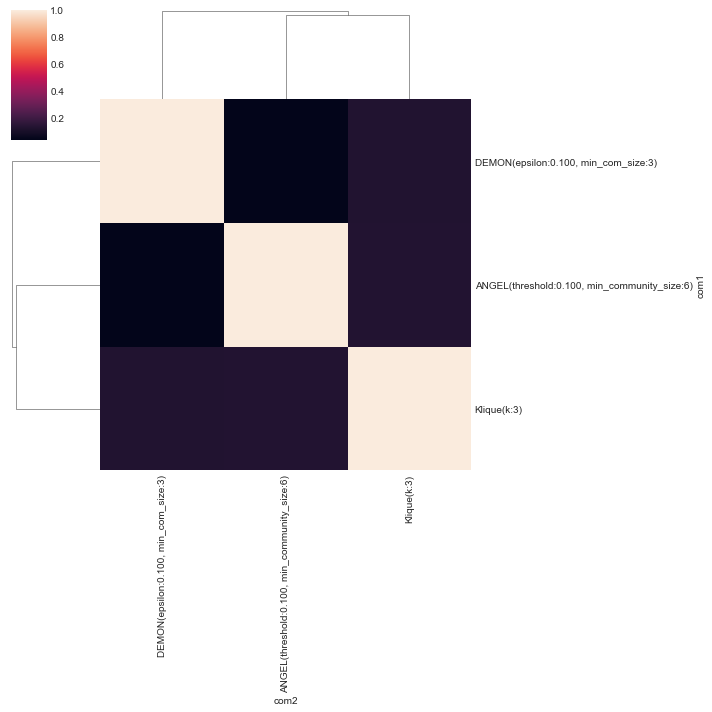

In [49]:
viz.plot_sim_matrix([demon_coms, angel_coms, kclique_coms],evaluation.overlapping_normalized_mutual_information_LFK)